In [ ]:
# Key Concepts
'''
1. Forward problem: θ → x (simulation)
2. Inverse problem: x → θ (what we're solving)
3. Posterior: P(θ|x) probability distribution over parameters
4. Prior: Initial assumptions about parameter ranges
'''
import pandas as pd
import os
import numpy as np
import sys

# seaparate into train and test set.
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import torch
from torch.distributions import Uniform, ExpTransform, TransformedDistribution #, AffineTransform
import torch.nn as nn
from sklearn.preprocessing import Normalizer
import joblib

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params_alice import *
from priors_SB import initialise_priors_SB28

# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
snap = ["044"]
# 12 bins!
n_bins_lf = 13
n_bins_colour = 13
bands = "all" # or just GALEX?
colours = False  # just for now, lets do UVLF
luminosity_functions = True
name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}"#_{n_bins_colour}"

# initialize CAMELS and load parameter info using camels.py
cam = camels(model=model, sim_set='SB28')

# trys to use Chris method here, get_x, get_theta directly from photometry files instead of intermediate txt files.


/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# parameter info file (df_info) is used for defining priors
# the actual parameter values come from the camels class which reads CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt

#  parameters defined here: /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt which is used for theta
df_pars = pd.read_csv('/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt', delim_whitespace=True)
print(df_pars)


# prior values come from this:
df_info = pd.read_csv("/disk/xray15/aem2/data/28pams/Info_IllustrisTNG_L25n256_28params.txt")
print(df_info)



          #Name    Omega0    sigma8  WindEnergyIn1e51erg  RadioFeedbackFactor  \
0        SB28_0  0.352541  0.694742              3.85743             1.519210   
1        SB28_1  0.172430  0.830154              1.03554             0.797734   
2        SB28_2  0.234683  0.705844              9.61416             3.380650   
3        SB28_3  0.440288  0.969259              2.14363             0.488165   
4        SB28_4  0.457152  0.786733              1.38466             0.325727   
...         ...       ...       ...                  ...                  ...   
2043  SB28_2043  0.457334  0.970226              8.89733             0.607197   
2044  SB28_2044  0.440496  0.786137              5.34131             0.880840   
2045  SB28_2045  0.234475  0.938760              1.49723             1.873430   
2046  SB28_2046  0.172613  0.612888             13.31250             0.363806   
2047  SB28_2047  0.352358  0.862216              3.09935             3.331570   

      VariableWindVelFactor

In [3]:
theta = df_pars.iloc[:, 1:29].to_numpy()  # excluding 'name' column and 'seed' column

print(theta)
print(theta.shape)

[[3.52541e-01 6.94742e-01 3.85743e+00 ... 2.25386e-01 2.69356e-04
  5.14648e-01]
 [1.72430e-01 8.30154e-01 1.03554e+00 ... 8.62311e-02 2.28022e-02
  2.62078e+00]
 [2.34683e-01 7.05844e-01 9.61416e+00 ... 6.48096e-01 1.45761e-03
  3.38956e+00]
 ...
 [2.34475e-01 9.38760e-01 1.49723e+00 ... 6.82619e-01 6.26319e-03
  3.11721e+00]
 [1.72613e-01 6.12888e-01 1.33125e+01 ... 8.36555e-02 7.09853e-05
  2.88794e+00]
 [3.52358e-01 8.62216e-01 3.09935e+00 ... 2.56220e-01 3.64932e-02
  9.94068e-01]]
(2048, 28)


In [4]:
print("Column names:")
print(df_pars.columns.tolist())

Column names:
['#Name', 'Omega0', 'sigma8', 'WindEnergyIn1e51erg', 'RadioFeedbackFactor', 'VariableWindVelFactor', 'RadioFeedbackReiorientationFactor', 'OmegaBaryon', 'HubbleParam', 'n_s', 'MaxSfrTimescale', 'FactorForSofterEQS', 'IMFslope', 'SNII_MinMass_Msun', 'ThermalWindFraction', 'VariableWindSpecMomentum', 'WindFreeTravelDensFac', 'MinWindVel', 'WindEnergyReductionFactor', 'WindEnergyReductionMetallicity', 'WindEnergyReductionExponent', 'WindDumpFactor', 'SeedBlackHoleMass', 'BlackHoleAccretionFactor', 'BlackHoleEddingtonFactor', 'BlackHoleFeedbackFactor', 'BlackHoleRadiativeEfficiency', 'QuasarThreshold', 'QuasarThresholdPower', 'seed']


(array([676., 348., 235., 178., 143., 121., 102.,  92.,  80.,  73.]),
 array([0.0250079 , 0.06248791, 0.09996792, 0.13744793, 0.17492794,
        0.21240795, 0.24988796, 0.28736797, 0.32484798, 0.36232799,
        0.399808  ]),
 <BarContainer object of 10 artists>)

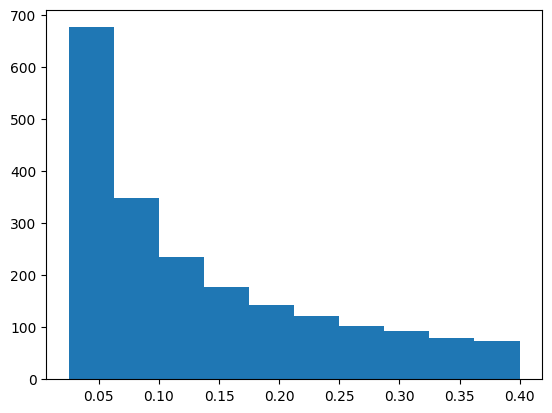

In [5]:
# plot the first one (omega0) to see shape of prior:
plt.hist(theta[:, 24])

In [6]:
'''  reference from setup_params_alice.py
def calc_df(_x, volume, massBinLimits):
    hist, _dummy = np.histogram(_x, bins=massBinLimits)
    hist = np.float64(hist)
    phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])

    phi_sigma = (np.sqrt(hist) / volume) / (
        massBinLimits[1] - massBinLimits[0]
    )  # Poisson errors

    return phi, phi_sigma, hist

def get_luminosity_function(
    photo,
    filt,
    lo_lim,
    hi_lim,
    n_bins=15,
    mask=None,
):
    h = 0.6711
    if mask is None:
        mask = np.ones(len(photo[filt]), dtype=bool)

    binLimits = np.linspace(lo_lim, hi_lim, n_bins)
    phi, phi_sigma, hist = calc_df(photo[filt][mask], (25 / h) ** 3, binLimits)
    phi[phi == 0.0] = 1e-6 + np.random.rand() * 1e-7
    phi = np.log10(phi)
    return phi, phi_sigma, hist, binLimits

def get_photometry(
    sim_name="LH_0",
    spec_type="attenuated",
    snap="090",
    sps="BC03",
    model="IllustrisTNG",
    photo_dir=("/disk/xray15/aem2/data/28pams/IllustrisTNG/photometry"),
    filters=[
        "SLOAN/SDSS.u",
        "SLOAN/SDSS.g",
        "SLOAN/SDSS.r",
        "SLOAN/SDSS.i",
        "SLOAN/SDSS.z",
        "GALEX FUV",
        "GALEX NUV",
    ],
):
    photo_file = f"{photo_dir}/{model}_{sim_name}_photometry.hdf5"
    photo = {}
    with h5py.File(photo_file, "r") as hf:
        for filt in filters:
            photo[filt] = hf[
                f"snap_{snap}/{sps}/photometry/luminosity/{spec_type}/{filt}"
            ][:]
            photo[filt] *= unyt_quantity.from_string("1 erg/s/Hz") 
            photo[filt] = lnu_to_absolute_mag(photo[filt])

    return photo
'''
def get_photometry_SB(
    sim_name="SB28_0",
    spec_type="attenuated",
    snap="044",
    sps="BC03",
    model="IllustrisTNG",
    photo_dir="/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/photometry",
    filters=["GALEX FUV", "GALEX NUV"],
):
    photo = {}
    with h5py.File(f"{photo_dir}/alice_galex.h5", "r") as hf:
        for filt in filters:
            path = f"{sim_name}/snap_{snap}/{sps}/photometry/luminosity/{spec_type}/{filt}"
            photo[filt] = hf[path][:]
            # comment out if data is already in desired format, remove conversion if not needed. in Chris function get_photometry so keep here.
            photo[filt] *= unyt_quantity.from_string("1 erg/s/Hz")
            photo[filt] = lnu_to_absolute_mag(photo[filt])
    return photo

def get_theta_SB(model="IllustrisTNG", device="cuda"):
    # theta is the number of simulation parameters so 28
    cam = camels(model=model, sim_set='SB28')
    theta = np.array([
        cam.params['Omega0'].values,              # Omega0
        cam.params['sigma8'].values,              # sigma8
        cam.params['WindEnergyIn1e51erg'].values, # Wind Energy in 1e51 erg
        cam.params['RadioFeedbackFactor'].values,  # Radio Feedback Factor
        cam.params['VariableWindVelFactor'].values, # Variable Wind Velocity Factor
        cam.params['RadioFeedbackReiorientationFactor'].values, # Radio Feedback Reorientation Factor
        cam.params['OmegaBaryon'].values,         # Omega Baryon
        cam.params['HubbleParam'].values,         # Hubble Parameter
        cam.params['n_s'].values,                 # n_s
        cam.params['MaxSfrTimescale'].values,     # Max SFR Timescale
        cam.params['FactorForSofterEQS'].values,  # Factor for Softer EQS
        cam.params['IMFslope'].values,            # IMF slope
        cam.params['SNII_MinMass_Msun'].values,   # SNII Minimum Mass (Msun)
        cam.params['ThermalWindFraction'].values, # Thermal Wind Fraction
        cam.params['VariableWindSpecMomentum'].values, # Variable Wind Specific Momentum
        cam.params['WindFreeTravelDensFac'].values, # Wind Free Travel Density Factor
        cam.params['MinWindVel'].values,          # Minimum Wind Velocity
        cam.params['WindEnergyReductionFactor'].values, # Wind Energy Reduction Factor
        cam.params['WindEnergyReductionMetallicity'].values, # Wind Energy Reduction Metallicity
        cam.params['WindEnergyReductionExponent'].values, # Wind Energy Reduction Exponent
        cam.params['WindDumpFactor'].values,      # Wind Dump Factor
        cam.params['SeedBlackHoleMass'].values,   # Seed Black Hole Mass
        cam.params['BlackHoleAccretionFactor'].values, # Black Hole Accretion Factor
        cam.params['BlackHoleEddingtonFactor'].values, # Black Hole Eddington Factor
        cam.params['BlackHoleFeedbackFactor'].values, # Black Hole Feedback Factor
        cam.params['BlackHoleRadiativeEfficiency'].values, # Black Hole Radiative Efficiency
        cam.params['QuasarThreshold'].values,     # Quasar Threshold
        cam.params['QuasarThresholdPower'].values # Quasar Threshold Power
    ]).T
    
    return torch.tensor(theta, dtype=torch.float32, device=device)
    

def get_x_SB( # get colours or LFs
    # x.shape= (no. sims, no. bins*features) 

        # 2 GALEX filters (FUV, NUV)
        # Each filter gets n_bins_lf (12) bins
        # 2 filters * 12 bins = 24 features
        # 1 color (FUV-NUV)
        # Gets n_bins_colour (9) bins
        # 1 color * 9 bins = 9 features

    # Total: 24 + 9 = 33 features per simulation with colours & UVLF but with just UVLF its 24
     
    spec_type="attenuated",
    snap="044",
    sps="BC03",
    luminosity_functions=True,
    colours=False, # true for later, lets do UVLF first.
    model="IllustrisTNG",
    photo_dir="/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/photometry",
    n_bins_lf=13,
    n_bins_colour=13,
):
    if isinstance(snap, str):
        snap = [snap]

    x = [[] for _ in range(2048)]  # For SB28 simulations

    for SB28_ in range(2048):
        try:
            for snp in snap:
                photo = get_photometry_SB(
                    sim_name=f"SB28_{SB28_}",
                    spec_type=spec_type,
                    snap=snp,
                    sps=sps,
                    model=model,
                    photo_dir=photo_dir,
                )

                if luminosity_functions:
                    for filt, lo_lim, hi_lim in zip(
                        ["GALEX FUV", "GALEX NUV"],
                        [-20.5, -20.5],
                        [-15, -15],
                    ):
                        phi = get_luminosity_function(
                            photo, filt, lo_lim, hi_lim, n_bins=n_bins_lf
                        )[0]
                        x[SB28_].append(phi)

                if colours:
                    binLimsColour = np.linspace(-0.5, 3.5, n_bins_colour)
                    color = photo["GALEX FUV"] - photo["GALEX NUV"]
                    color_dist = np.histogram(color, binLimsColour, density=True)[0]
                    x[SB28_].append(color_dist)
        except Exception as e:
            print(f"Error processing simulation {SB28_}: {e}")
            x[SB28_] = None

    # Remove any failed simulations
    x = [xi for xi in x if xi is not None]
    
    return x


def get_theta_x_SB(
    spec_type="attenuated",
    snap="044",
    sps="BC03",
    model="IllustrisTNG",
    device="cuda",
    **kwargs,
):
    x = get_x_SB(spec_type=spec_type, snap=snap, sps=sps, model=model, **kwargs)
    theta = get_theta_SB(model=model, device=device)
    
    # Convert x list to proper array format
    x_array = np.array([np.hstack(_x) for _x in x])
    return theta, x_array


if __name__ == "__main__":
    theta, x = get_theta_x_SB()
    print(theta.shape, x.shape)


torch.Size([2048, 28]) (2048, 24)


In [7]:

# get the priors and data
prior = initialise_priors_SB28(
    df=df_info, 
    device=device,
    astro=True,
    dust=False  # no dust for testing. set to False to only get the 28 model parameters.
    # with dust = True, prior has 32 dimensions (28 parameters + 4 dust parameters) 
)

theta, x = get_theta_x_SB(
    spec_type=spec_type,
    snap=snap,
    sps=sps,
    model=model,
    device=device,
    n_bins_lf=n_bins_lf,
    n_bins_colour=n_bins_colour,
    photo_dir="/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/photometry"
)

# process the data
x_all = np.array([np.hstack(_x) for _x in x])
x_all = torch.tensor(x_all, dtype=torch.float32, device=device)

print("Theta shape:", theta.shape)
print("X shape:", x_all.shape)

processing Omega0:
processing Omega0 is linear with min 0.1 and max 0.5:
processing sigma8:
processing sigma8 is linear with min 0.6 and max 1.0:
processing WindEnergyIn1e51erg:
processing WindEnergyIn1e51erg is logarithmic with min 0.9 and max 14.4:
processing RadioFeedbackFactor:
processing RadioFeedbackFactor is logarithmic with min 0.25 and max 4.0:
processing VariableWindVelFactor:
processing VariableWindVelFactor is logarithmic with min 3.7 and max 14.8:
processing RadioFeedbackReiorientationFactor:
processing RadioFeedbackReiorientationFactor is logarithmic with min 10.0 and max 40.0:
processing OmegaBaryon:
processing OmegaBaryon is linear with min 0.029 and max 0.069:
processing HubbleParam:
processing HubbleParam is linear with min 0.4711 and max 0.8711:
processing n_s:
processing n_s is linear with min 0.7624 and max 1.1624:
processing MaxSfrTimescale:
processing MaxSfrTimescale is logarithmic with min 1.135 and max 4.54:
processing FactorForSofterEQS:
processing FactorForSo

/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 28 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(


Theta shape: torch.Size([2048, 28])
X shape: torch.Size([2048, 24])


In [8]:
# mask for test fraction (10% currently)
def create_test_mask(n_sims=2048, test_fraction=0.1, random_seed=42):
    """
    Create a test mask similar to the LH one but for SB 2048 simulations.
    
    Args:
        n_sims: Number of simulations (2048 for SB28)
        test_fraction: Fraction of simulations to use for testing (0.1 = 10%)
        random_seed: Random seed for reproducibility
    
    Returns:
        np.array: Boolean mask where True indicates test set
    """
    np.random.seed(random_seed)
    test_mask = np.random.rand(n_sims) > (1 - test_fraction)
    
    # Print some statistics
    print(f"Total simulations: {n_sims}")
    print(f"Test set size: {test_mask.sum()}")
    print(f"Training set size: {(~test_mask).sum()}")
    print(f"Test fraction: {test_mask.sum() / n_sims:.3f}")
    
    # Save the mask
    save_path = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/test/test_mask_SB28.txt"
    np.savetxt(save_path, test_mask.astype(int), fmt='%i')
    
    return test_mask


In [9]:

# Move data to GPU as early as possible
x_all = x_all.to(device)
x_all


tensor([[-3.7726, -3.4204, -3.6757,  ..., -2.9944, -3.0129, -2.8975],
        [-4.3746, -4.0736, -3.2607,  ..., -2.5551, -2.5113, -2.4715],
        [-3.5965, -3.5295, -3.5965,  ..., -2.6265, -2.7619, -2.7412],
        ...,
        [-5.9844, -3.5965, -3.3332,  ..., -2.6671, -2.6844, -2.7312],
        [-5.9842, -5.9842, -5.9842,  ..., -3.4715, -3.4715, -3.5965],
        [-4.0736, -3.3746, -2.9944,  ..., -2.3535, -2.4252, -2.3177]],
       device='cuda:0')

In [10]:
theta = torch.tensor(theta, dtype=torch.float32, device=device)
theta

/tmp/ipykernel_3562700/964306182.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32, device=device)


tensor([[3.5254e-01, 6.9474e-01, 3.8574e+00,  ..., 2.2539e-01, 2.6936e-04,
         5.1465e-01],
        [1.7243e-01, 8.3015e-01, 1.0355e+00,  ..., 8.6231e-02, 2.2802e-02,
         2.6208e+00],
        [2.3468e-01, 7.0584e-01, 9.6142e+00,  ..., 6.4810e-01, 1.4576e-03,
         3.3896e+00],
        ...,
        [2.3448e-01, 9.3876e-01, 1.4972e+00,  ..., 6.8262e-01, 6.2632e-03,
         3.1172e+00],
        [1.7261e-01, 6.1289e-01, 1.3312e+01,  ..., 8.3655e-02, 7.0985e-05,
         2.8879e+00],
        [3.5236e-01, 8.6222e-01, 3.0993e+00,  ..., 2.5622e-01, 3.6493e-02,
         9.9407e-01]], device='cuda:0')

In [ ]:
# Handle NaN values and normalize while on GPU
x_all_cpu = x_all.cpu().numpy()  # Only move to CPU when necessary for sklearn
x_all_cpu


array([[-3.7725797, -3.4203973, -3.6756697, ..., -2.9944284, -3.012912 ,
        -2.8975184],
       [-4.37464  , -4.07361  , -3.2606964, ..., -2.555096 , -2.5113168,
        -2.4715497],
       [-3.5964885, -3.5295417, -3.5964885, ..., -2.6264517, -2.7618558,
        -2.7411714],
       ...,
       [-5.984362 , -3.5964885, -3.3332472, ..., -2.6670697, -2.6844437,
        -2.731187 ],
       [-5.984223 , -5.984223 , -5.984223 , ..., -3.4715497, -3.4715497,
        -3.5964885],
       [-4.07361  , -3.3746397, -2.9944284, ..., -2.3534505, -2.4252498,
        -2.317735 ]], dtype=float32)

In [ ]:
print("Data shape before processing:", x_all_cpu.shape)
print("Number of values:",(x_all_cpu).sum())
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())

# how many nan values are there? if they are all nan something has gone horribly wrong.
# this looks better - 18th Nov

Data shape before processing: (2048, 24)
Number of values: -149258.66
Number of NaN values: 0
Number of infinite values: 0


In [ ]:

# get rid of NaN/inf values, replace with small random noise
nan_mask = np.isnan(x_all_cpu) | np.isinf(x_all_cpu)
nan_mask



array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [14]:

if nan_mask.any():
    x_all_cpu[nan_mask] = np.random.rand(np.sum(nan_mask)) * 1e-10


In [15]:
x_all_cpu

array([[-3.7725797, -3.4203973, -3.6756697, ..., -2.9944284, -3.012912 ,
        -2.8975184],
       [-4.37464  , -4.07361  , -3.2606964, ..., -2.555096 , -2.5113168,
        -2.4715497],
       [-3.5964885, -3.5295417, -3.5964885, ..., -2.6264517, -2.7618558,
        -2.7411714],
       ...,
       [-5.984362 , -3.5964885, -3.3332472, ..., -2.6670697, -2.6844437,
        -2.731187 ],
       [-5.984223 , -5.984223 , -5.984223 , ..., -3.4715497, -3.4715497,
        -3.5964885],
       [-4.07361  , -3.3746397, -2.9944284, ..., -2.3534505, -2.4252498,
        -2.317735 ]], dtype=float32)

In [16]:
print("Data shape before processing:", x_all_cpu.shape)
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())


Data shape before processing: (2048, 24)
Number of NaN values: 0
Number of infinite values: 0


In [17]:

# Normalize
norm = Normalizer()
x_all_normalized = norm.fit_transform(x_all_cpu)
x_all = torch.tensor(x_all_normalized, dtype=torch.float32, device=device)
x_all

tensor([[-0.2380, -0.2158, -0.2319,  ..., -0.1889, -0.1901, -0.1828],
        [-0.2798, -0.2606, -0.2086,  ..., -0.1634, -0.1606, -0.1581],
        [-0.2360, -0.2316, -0.2360,  ..., -0.1723, -0.1812, -0.1799],
        ...,
        [-0.3668, -0.2204, -0.2043,  ..., -0.1635, -0.1645, -0.1674],
        [-0.2732, -0.2732, -0.2732,  ..., -0.1585, -0.1585, -0.1642],
        [-0.3031, -0.2511, -0.2228,  ..., -0.1751, -0.1805, -0.1725]],
       device='cuda:0')

In [18]:

# Save normalizer
joblib.dump(norm, f'/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/{name}_scaler.save')

# Print final check
print("Any NaN in normalized data:", torch.isnan(x_all).any().item())
print("Any inf in normalized data:", torch.isinf(x_all).any().item())


Any NaN in normalized data: False
Any inf in normalized data: False


In [19]:

# make test mask
test_mask = create_test_mask() # 10% testing
test_mask


Total simulations: 2048
Test set size: 203
Training set size: 1845
Test fraction: 0.099


array([False,  True, False, ..., False, False, False])

In [21]:
train_mask = ~test_mask # 90% for training
train_mask


array([ True, False,  True, ...,  True,  True,  True])

# original

hidden_features = 30
num_transforms = 4
nets = [
    # ili.utils.load_nde_sbi(
    #     engine="NLE", model="maf", hidden_features=50, num_transforms=5
    # ),
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="nsf", hidden_features=hidden_features, num_transforms=num_transforms
    ),
    '''

    ili.utils.load_nde_sbi(
        engine="NPE",
        model="nsf", hidden_features=hidden_features, num_transforms=num_transforms
    ),
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="nsf", hidden_features=hidden_features, num_transforms=num_transforms
    ),
    # ili.utils.load_nde_sbi(
    #     engine="NPE",
    #     model="nsf", hidden_features=hidden_features, num_transforms=num_transforms
    # ),
    # ili.utils.load_nde_lampe(model="nsf", device=device, hidden_features=20, num_transforms=2), 
    # ili.utils.load_nde_lampe(model="nsf", device=device, hidden_features=20, num_transforms=2), 
    '''
]
print(nets)


train_args = {"training_batch_size": 4, "learning_rate": 5e-4, 'stop_after_epochs': 20}
print(train_args)


loader = NumpyLoader(
    x=x_all[~test_mask],
    # theta=torch.tensor(theta[~test_mask], device=device)
    theta=torch.tensor(theta[~test_mask, :], device=device)
)
print(loader)

runner = InferenceRunner.load(
    backend="sbi",  #'sbi', # 'lampe',
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    # embedding_net=None,
    out_dir="models/",
    name=name,
)
print(runner)

posterior_ensemble, summaries = runner(loader=loader)
print(posterior_ensemble)

In [ ]:
# Configure network properly
hidden_features = 30
num_transforms = 4
net = ili.utils.load_nde_sbi(
    engine="NPE",                       # Neural Posterior Estimation
    model="nsf",                        # Neural Spline Flow
    hidden_features=hidden_features,    # Network width
    num_transforms=num_transforms,      # Network depth
    # Remove device parameter as it's not allowed
)

# Training arguments
train_args = {
    "training_batch_size": 128,
    "learning_rate": 1e-3,
    "stop_after_epochs": 20
}

# Data loader
loader = NumpyLoader(
    # x = x_all[train_mask]
    # theta=theta[train_mask]
   
    x_train=x_all[train_mask].clone().detach(),
    theta_train=theta[train_mask].clone().detach()
)

# Runner setup with device specified here
runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=[net],
    device=device,  # Device specified in runner, not network
    train_args=train_args,
    proposal=None,
    out_dir="/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/",
    name=name
)

# Run training
posterior_ensemble, summaries = runner(loader=loader)

# process of training:
'''
- the neural network learns P(θ|x): probability of parameters given observations
- uses training data to learn mapping from x → θ
- then we validate on held-out portion of training data
'''


INFO:root:MODEL INFERENCE CLASS: NPE


/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 1.


 Neural network successfully converged after 47 epochs.

/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 216.89492869377136 seconds to train models.
INFO:root:Saving model to /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models


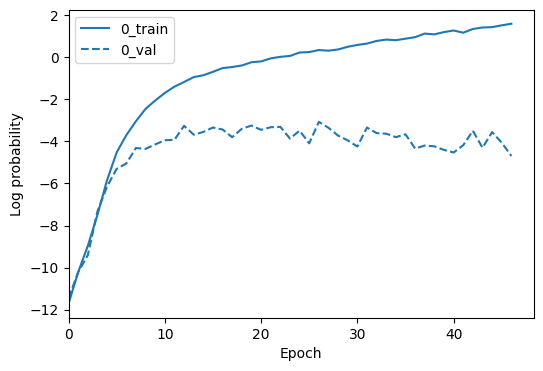

In [23]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [24]:
"""
Coverage plots for each model
"""
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    # sample_method="slice_np_vectorized",
    # sample_params={'num_chains': 1},
    # sample_method="vi",
    # sample_params={"dist": "maf", "n_particles": 32, "learning_rate": 1e-2},
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp"],
    out_dir="/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots",
)
metric

  0%|          | 0/203 [00:00<?, ?it/s]/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(
100%|██████████| 203/203 [01:45<00:00,  1.92it/s]
INFO:root:Saving coverage plot to /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/coverage_IllustrisTNG_all_BC03_attenuated_13_plot_coverage.jpg...
INFO:root:Saving ranks histogram to /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/coverage_IllustrisTNG_all_BC03_attenuated_13_ranks_histogram.jpg...
100%|██████████| 100/100 [

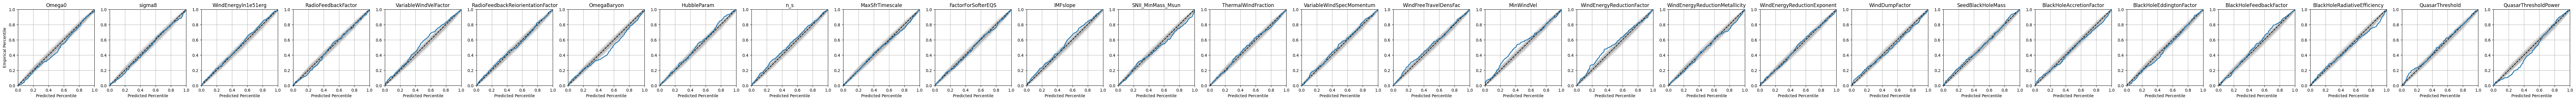

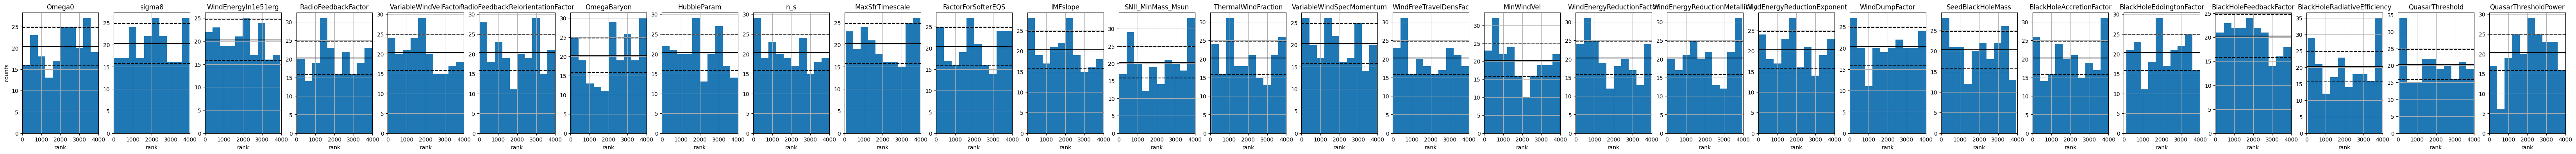

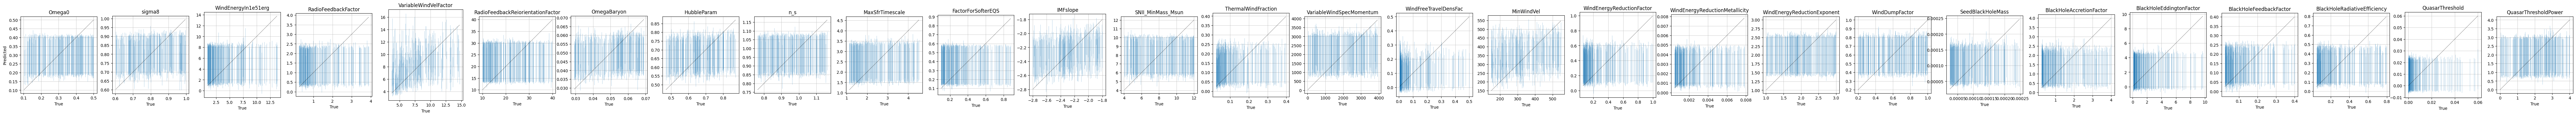

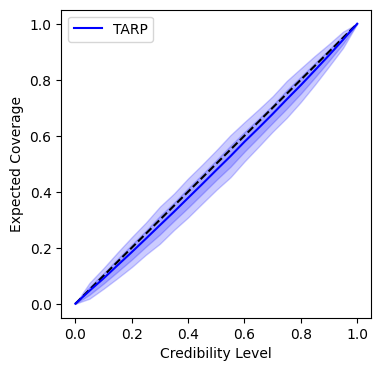

In [25]:

fig = metric(
    posterior=posterior_ensemble,
    x=x_all[test_mask].cpu(),
    # theta=theta[test_mask].cpu(),
    theta=theta[test_mask, :].cpu(),
    signature=f"coverage_{name}_",
)

In [ ]:

# Setup parameters
''' dont need these again, just a reminder.
model = "IllustrisTNG"
bands = "GALEX"
sps = "BC03"
spec_type = "attenuated"
n_bins_lf = 12
name = f"{model}_{bands}_LF_{sps}_{spec_type}_{n_bins_lf}"

'''

# 5. Plot Training Progress
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(summaries)))
for i, summary in enumerate(summaries):
    ax.plot(summary['training_log_probs'], 
            ls='-', label=f'Train {i}', color=colors[i])
    ax.plot(summary['validation_log_probs'], 
            ls='--', label=f'Val {i}', color=colors[i])
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.set_title('Training Progress')
ax.legend()
plt.savefig(f'/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/training_progress_{name}.png')
plt.close()

# test Sampling
# define here:
x_test=x_all[test_mask].clone().detach()
theta_test=theta[test_mask].clone().detach()

test_ind = np.random.randint(len(x_test))
x_input = torch.tensor(x_test[test_ind], dtype=torch.float32).to(device)

# Sample from posterior
samples = posterior_ensemble.sample(
    (1000,),
    x=x_input,
    show_progress_bars=True
)

# Move to CPU for plotting
samples_cpu = samples.cpu().numpy()
theta_true = theta[test_ind].cpu().numpy()

# 7. Plot Results for all parameters in 4x7 grid
fig = plt.figure(figsize=(28, 16))
gs = gridspec.GridSpec(4, 7)
gs.update(wspace=0.3, hspace=0.4)

for param_idx in range(28):
    row = param_idx // 7
    col = param_idx % 7
    ax = plt.subplot(gs[row, col])
    
    # Create histogram
    ax.hist(samples_cpu[:, param_idx], bins=50, density=True, alpha=0.7, color='skyblue')
    ax.axvline(theta_true[param_idx], color='r', linestyle='--', label='True')
    ax.set_title(f'{cam.labels[param_idx]}', fontsize=10)
    ax.tick_params(labelsize=8)
    if param_idx % 7 == 0:  # Add y-label only for leftmost plots
        ax.set_ylabel('Density')
    ax.legend(fontsize=8)

plt.suptitle(f'Posterior Distributions - {name}', fontsize=14, y=1.02)
plt.savefig(f'/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/posteriors_grid_{name}.png',
            dpi=300, bbox_inches='tight')
plt.close()

# Alternatively, save individual plots
for param_idx in range(28):
    plt.figure(figsize=(8, 6))
    plt.hist(samples_cpu[:, param_idx], bins=50, density=True, alpha=0.7, color='skyblue')
    plt.axvline(theta_true[param_idx], color='r', linestyle='--', label='True')
    plt.title(f'{cam.labels[param_idx]}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(f'/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/posterior_{cam.labels[param_idx]}_{name}.png',
                dpi=300, bbox_inches='tight')
    plt.close()

# 8. Dimension Verification
print("\nDimension Check:")
print(f"Training data:")
print(f"X shape: {x_test.shape}")
print(f"Theta shape: {theta_test.shape}")
print(f"\nTest data:")
print(f"X shape: {x_test.shape}")
print(f"Theta shape: {theta_test.shape}")
print(f"\nSampled posterior shape: {samples_cpu.shape}")

# 9. Coverage Analysis
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp"],
    out_dir="/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots"
)

fig = metric(
    posterior=posterior_ensemble,
    x=x_all[test_mask].cpu(),
    theta=theta[test_mask].cpu(),
    signature=f"coverage_{name}_"
)

In [ ]:

# Test sampling and grid plotting
test_ind = np.random.randint(len(x_train))
x_input = torch.tensor(x_train[test_ind], dtype=torch.float32).to(device)
samples = safe_sample_posterior(x_input)

if samples is not None:
    samples = samples.cpu().numpy()
    
    # Create 4x7 subplot grid
    fig = plt.figure(figsize=(28, 16))
    gs = gridspec.GridSpec(4, 7)
    gs.update(wspace=0.3, hspace=0.4)
    
    # Plot all 28 parameters
    for i in range(28):
        row = i // 7
        col = i % 7
        ax = plt.subplot(gs[row, col])
        
        # Create histogram
        ax.hist(samples[:, i], bins=30, density=True, alpha=0.7, color='skyblue')
        # Add true value line
        ax.axvline(theta_train[test_ind, i], color='red', linestyle='--', label='True')
        # Add title using camels labels
        ax.set_title(cam.labels[i], fontsize=10)
        # Add legend
        ax.legend(fontsize=8)
        # Rotate x-axis labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    plt.savefig(f'/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/posterior_grid_{name}.png', 
                dpi=300, bbox_inches='tight')
    plt.close()

# Coverage metrics
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp"],
    out_dir="/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots",
)

# Generate coverage plots
fig = metric(
    posterior=posterior_ensemble,
    x=x_all[test_mask].cpu(),
    theta=theta[test_mask, :].cpu(),
    signature=f"coverage_{name}_",
)

# Add a summary plot showing key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

# Coverage plot
axes[0].plot(metric.coverage_probabilities, metric.coverage_fractions)
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('Expected Coverage')
axes[0].set_ylabel('Actual Coverage')
axes[0].set_title('Coverage Analysis')

# TARP plot (if available)
if hasattr(metric, 'tarp_scores'):
    axes[1].bar(range(len(metric.tarp_scores)), metric.tarp_scores)
    axes[1].set_xlabel('Parameter')
    axes[1].set_ylabel('TARP Score')
    axes[1].set_title('TARP Analysis')

# Parameter recovery plot
param_means = np.mean(samples, axis=0)
param_stds = np.std(samples, axis=0)
axes[2].errorbar(range(28), param_means, yerr=param_stds, fmt='o')
axes[2].set_xlabel('Parameter Index')
axes[2].set_ylabel('Value')
axes[2].set_title('Parameter Recovery')

# Correlation matrix
corr_matrix = np.corrcoef(samples.T)
im = axes[3].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[3].set_title('Parameter Correlations')
plt.colorbar(im, ax=axes[3])

plt.tight_layout()
plt.savefig(f'/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/summary_metrics_{name}.png', 
            dpi=300, bbox_inches='tight')
plt.close()

# Create a single figure for all plots
fig = plt.figure(figsize=(28, 20))  # Adjusted figure size for better proportions
gs = gridspec.GridSpec(nrows=4, ncols=7, figure=fig)
gs.update(wspace=0.3, hspace=0.4)  # Adjust spacing between subplots

for param_idx in range(28):
    row = param_idx // 7    # Integer division for row number
    col = param_idx % 7     # Remainder for column number
    
    ax = fig.add_subplot(gs[row, col])
    
    # Coverage plot
    if row == 0:  # First row - coverage plots
        ax.hist(samples_cpu[:, param_idx], bins=50, density=True, alpha=0.7, color='skyblue')
        ax.axvline(theta_true[param_idx], color='r', linestyle='--', label='True')
    
    # Rank histograms
    elif row == 1:  # Second row - rank histograms
        ax.hist(samples_cpu[:, param_idx], bins=20, density=True, alpha=0.7, color='lightgreen')
    
    # Predictions
    elif row == 2:  # Third row - prediction plots
        ax.hist(samples_cpu[:, param_idx], bins=30, density=True, alpha=0.7, color='lightcoral')
    
    # Parameter distributions
    else:  # Fourth row - parameter distributions
        ax.hist(samples_cpu[:, param_idx], bins=40, density=True, alpha=0.7, color='lightblue')
    
    # Common formatting
    ax.set_title(f'{cam.labels[param_idx]}', fontsize=10)
    ax.tick_params(labelsize=8)
    ax.set_xlabel('Value', fontsize=8)
    if col == 0:  # Only add y-label for leftmost plots
        ax.set_ylabel('Density', fontsize=8)

# Add overall title
plt.suptitle(f'Parameter Analysis - {name}', fontsize=14, y=1.02)

# Save plot
plt.savefig(f'/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/parameter_analysis_{name}.png',
            dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
# 7x4  layout for coverage metrics
def plot_coverage_4x7(metric, name):
    fig = plt.figure(figsize=(28, 20))
    gs = gridspec.GridSpec(4, 7)
    gs.update(wspace=0.3, hspace=0.4)
    
    # plot each metric in its own row
    for param_idx in range(28):
        row = param_idx // 7
        col = param_idx % 7
        ax = plt.subplot(gs[row, col])
        
        # formatting parameters
        ax.set_title(f'{cam.labels[param_idx]}', fontsize=10)
        ax.tick_params(labelsize=8)
        if col == 0:  # y-label only for leftmost plots
            ax.set_ylabel('Density')

    plt.suptitle(f'Coverage Analysis - {name}', fontsize=14, y=1.02)
    plt.savefig(f'/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/coverage_analysis_{name}.png',
                dpi=300, bbox_inches='tight')
    plt.close()

# coverage analysis
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp"],
    out_dir="/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots"
)

# get coverage analysis
fig = metric(
    posterior=posterior_ensemble,
    x=x_all[test_mask].cpu(),
    theta=theta[test_mask].cpu(),
    signature=f"coverage_{name}_"
)

# make in 4x7 grid
plot_coverage_4x7(metric, name)
